The objective of this notebook is to run BOW and Multinomial Naive Bayes as our baseline model to have a reference in our experimentation


## Datasets

In [37]:
import pandas as pd
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv("../../data/gold/train.csv")
test = pd.read_csv("../../data/gold/test.csv")
val = pd.read_csv("../../data/gold/validation.csv")

X_train = train['features']
y_train = train['target']
X_test = test['features']
y_test = test['target']
signature = infer_signature(X_train, y_train)

## Pipeline

In [38]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc,
    balanced_accuracy_score,
)


pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 1), max_features=None)),
        ('classifier', MultinomialNB())
    ])
    
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)


In [39]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {test_accuracy:.2f} ")

Accuracy: 0.98 


Notes: 

As expected our model has a high accuracy that doesn't mean much since the dataset is imbalanced

In [40]:
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Balanced Accuracy: 0.97


Notes: 

The model is correctly identifying both spam and non-spam messages with a high level of recall.

In [41]:
# F0.5-Score
f0_5_score = fbeta_score(y_test, y_test_pred, beta=0.5)
print(f"F0.5-Score: {f0_5_score:.2f}")

F0.5-Score: 0.90


In [42]:
report = classification_report(y_test, y_test_pred)
print("Classification Report (Test Data):")
print(report)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       453
           1       0.88      0.95      0.92        63

    accuracy                           0.98       516
   macro avg       0.94      0.97      0.95       516
weighted avg       0.98      0.98      0.98       516



Notes:

- f0.5-score: the metric chosen since I want to give more important to the false positives. A value of 0.85 indicates good performance of the model. 
- Precision: 82% of the predicted positives are true positives. Good performance.
- Recall: 95% of the real positives are true positives. Good performance.
- F1-score: the model is doing a decent job but since the dataset is imbalanced and I want to focus on the false positives, I take it with a grain of salt. 
- Accuracy and macro avg can be ignored.
- Weighted avgs: they also look good but we have to remember that depending on the disbalance of our dataset, these values can hide issues.  

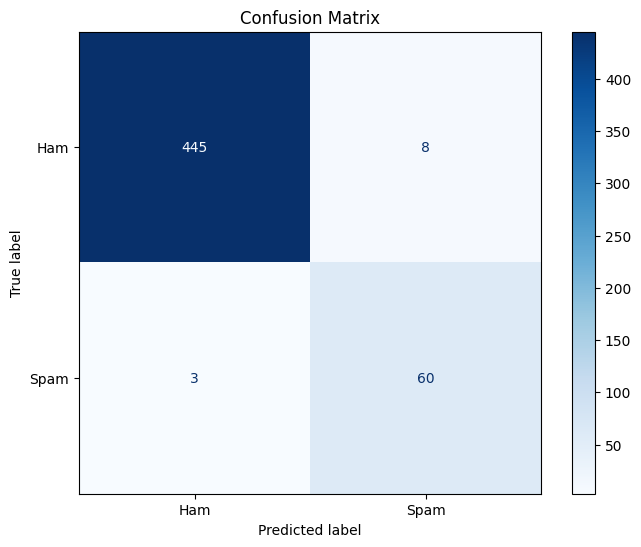

In [43]:
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
matrix_fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Ham', 'Spam'])
cm_display.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.show()

Notes:

The confusion matrix looks very good.
- 13 e-mails were predicted as SPAM but they were HAM. (these are the ones I will try to minimize)
- 3 e-mails were predicted as HAM but they were SPAM.

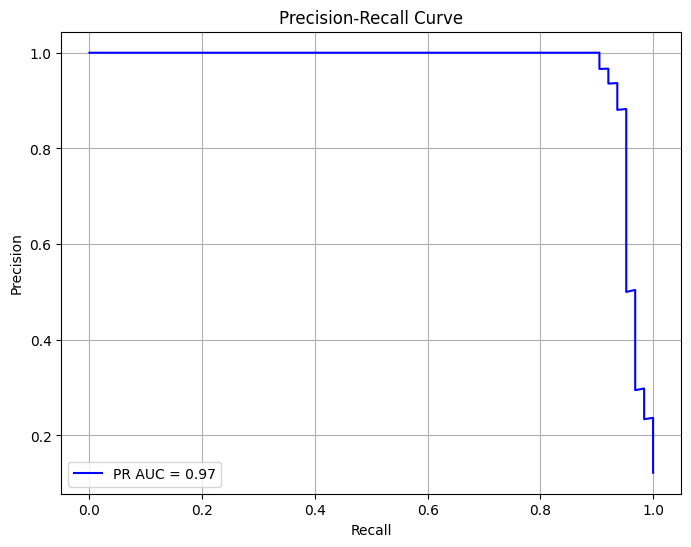

In [44]:
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)
pr_auc = auc(recall, precision)

pr_fig, ax = plt.subplots(figsize=(8, 6))  
ax.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc="best")
ax.grid(True)
plt.show()


Notes: 

The area under the curve is 0.96 so the model strikes a strong balance between precision and recall across thresholds. The model identifies spam effectively without producing excessive false positives.

## MLFlow config


In [ ]:
from experiments_utils import experiment_status
import mlflow

import os
mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_status()

('spam-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'NLP-text-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [46]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts
# mlflow.search_experiments()

# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [47]:
experiment_name, _, _ = experiment_status()
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/home/maldu/dscience/projects/spam_detector/notebooks/experimentation/artifacts/1', creation_time=1733501883396, experiment_id='1', last_update_time=1733501883396, lifecycle_stage='active', name='spam-classifier', tags={}>

## MlFlow tracking

In [48]:
   
with mlflow.start_run(run_name="baseline-model", log_system_metrics=True) as run:
    
    # Tags
    mlflow.set_tag("model", "Reference model MultinomialNB + BOW")
    mlflow.set_tag("developer", "Mldu")
    mlflow.set_tag("version", "1.0.0")
    mlflow.set_tag("project_stage", "testing")

    #Datasets
    mlflow.log_input(mlflow.data.from_pandas(train, name="train dataset", targets="target"))
    mlflow.log_input(mlflow.data.from_pandas(test, name="test dataset", targets="target"))
    mlflow.log_input(mlflow.data.from_pandas(val, name="validation dataset", targets="target"))
    mlflow.log_artifact("../../data/gold/train.csv")
    mlflow.log_artifact("../../data/gold/test.csv")
    mlflow.log_artifact("../../data/gold/validation.csv")

    
    #BOW and model
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("model_type", "MultinomialNB")
    
    # Metrics
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("f0_5_score", f0_5_score)
    cr = classification_report(y_test, y_test_pred, output_dict=True)
    mlflow.log_metric("accuracy", cr.pop("accuracy"))
    for class_or_avg, metrics_dict in cr.items():
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric,value)
    
    # Figures
    mlflow.log_figure(matrix_fig, "confusion-matrix.png")
    mlflow.log_figure(pr_fig, "precision-recall-curve.png")
    
    # CountVectorizer and MNB
    mlflow.sklearn.log_model(pipeline, "pipeline",signature=signature)
    
    # Notebook's name as tag and save as artifact
    notebook_name = os.path.basename(globals()['__vsc_ipynb_file__'])   
    mlflow.set_tag("source_notebook", f"{notebook_name}")
    mlflow.log_artifact(f"{notebook_name}", artifact_path="notebooks")


    print(f"Pipeline logged to MLflow under run ID {run.info.run_id}")

2024/12/06 17:58:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


2024/12/06 17:58:50 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/06 17:58:50 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Pipeline logged to MLflow under run ID cef71d8d4a724c069c2f17a0b833ec38
🏃 View run baseline-model at: http://127.0.0.1:5000/#/experiments/1/runs/cef71d8d4a724c069c2f17a0b833ec38
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Conclusions:

- Clear overfitting 
- The model is not predicting at random since the accuracy is higher than the imbalance